Preprocessing the data

In [ ]:
import os
from PIL import Image
import numpy as np
from torchvision import transforms

# 1) Point this to the root of your dataset, where each subfolder is one person/class:
DATA_DIR = r"E:/Iris/Dataset"

# 2) Build a list of class names (folder names) and sort for consistent label ordering
classes = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])

# 3) Define your preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),    
    transforms.Resize((256, 256)),                  
    transforms.ToTensor(),                          
    transforms.Normalize(mean=[0.5], std=[0.5])     
])

images, labels = [], []

# 4) Loop over classes and images
for label_idx, cls in enumerate(classes):
    class_dir = os.path.join(DATA_DIR, cls)
    for fname in os.listdir(class_dir):
        if not fname.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
            continue
        path = os.path.join(class_dir, fname)
        try:
            img = Image.open(path)
        except:
            print(f"Could not open {path}, skipping.")
            continue
        img_t = preprocess(img)                
        images.append(img_t.numpy())          
        labels.append(label_idx)

# 5) Stack into arrays
images = np.stack(images, axis=0)             
labels = np.array(labels, dtype=np.int64)    

# 6) Save
np.save("iris_images_256.npy", images)
np.save("iris_labels.npy", labels)

print(f"Saved {len(images)} images across {len(classes)} classes.")
print("iris_images_256.npy shape:", images.shape)
print("iris_labels.npy shape:", labels.shape)


Saved 10000 images across 1000 classes.
iris_images_256.npy shape: (10000, 1, 256, 256)
iris_labels.npy shape: (10000,)


Add Augmentations to Your Training Transform

In [ ]:
import os, random, numpy as np, torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

# 1) Load your preprocessed arrays
images = np.load("iris_images_256.npy")
labels = np.load("iris_labels.npy")       

# 2) Define transforms
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(256, scale=(0.9,1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])
val_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

class IrisPairDataset(Dataset):
    def __init__(self, images, labels, transform):
        self.images = images      # NumPy: (N,1,256,256)
        self.labels = labels      
        self.transform = transform
        self.label_to_indices = {}
        for i,l in enumerate(labels):
            self.label_to_indices.setdefault(int(l), []).append(i)
        self.classes = list(self.label_to_indices.keys())

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # 1) pick your anchor and label
        img1_np = self.images[idx]    
        lbl1   = int(self.labels[idx])

        # 2) choose a positive or negative
        if random.random() < 0.5:
            pos_idx = random.choice(self.label_to_indices[lbl1])
            img2_np = self.images[pos_idx]
            lbl = 1.0
        else:
            neg_lbl = random.choice([c for c in self.classes if c!=lbl1])
            neg_idx = random.choice(self.label_to_indices[neg_lbl])
            img2_np = self.images[neg_idx]
            lbl = 0.0

        # 3) convert back to uint8 grayscale for PIL
        def to_pil(img_np):
            # img_np shape (1,256,256), values ~[-1,1]
            arr = ((img_np.squeeze() + 1.0)/2.0 * 255.0).clip(0,255).astype(np.uint8)
            return Image.fromarray(arr, mode="L")

        pil1 = to_pil(img1_np)
        pil2 = to_pil(img2_np)

        # 4) apply your transform (PIL→Tensor→Normalize)
        img1 = self.transform(pil1)
        img2 = self.transform(pil2)

        return img1, img2, torch.tensor(lbl, dtype=torch.float32)

# 4) Split into train / val
idxs = np.arange(len(images))
train_idx, val_idx = train_test_split(idxs, test_size=0.15,
                                      stratify=labels, random_state=42)
train_ds = IrisPairDataset(images[train_idx], labels[train_idx], train_transform)
val_ds   = IrisPairDataset(images[val_idx],   labels[val_idx],   val_transform)

# 5) DataLoaders with num_workers=0 (so you see results immediately)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0)

# 6) Sanity check one batch
for img1_batch, img2_batch, lbl_batch in train_loader:
    print("img1:", img1_batch.shape)   # → [32,1,256,256]
    print("img2:", img2_batch.shape)   # → [32,1,256,256]
    print("lbls:", lbl_batch.shape)    # → [32]
    break


img1: torch.Size([32, 1, 256, 256])
img2: torch.Size([32, 1, 256, 256])
lbls: torch.Size([32])


Define your embedding network and the triplet‐loss

1: Embedding network

In [3]:
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

class IrisEmbeddingNet(nn.Module):
    def __init__(self, pretrained=True, embed_dim=128):
        super().__init__()
        # load pretrained
        self.net = EfficientNet.from_pretrained('efficientnet-b0') if pretrained \
                   else EfficientNet.from_name('efficientnet-b0')
        # first conv → 1 channel
        self.net._conv_stem = nn.Conv2d(
            in_channels=1, out_channels=32,
            kernel_size=(3,3), stride=(2,2), padding=(1,1), bias=False
        )
        # replace head → embedding
        in_feats = self.net._fc.in_features
        self.net._fc = nn.Linear(in_feats, embed_dim)

    def forward(self, x):
        # x: [B,1,256,256] → [B, embed_dim]
        return self.net(x)


2: Triplet‐loss

In [4]:
import torch.nn.functional as F

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # compute pairwise (Euclidean) distances
        pos_d = F.pairwise_distance(anchor, positive, p=2)
        neg_d = F.pairwise_distance(anchor, negative, p=2)
        # loss = max(0, pos_d - neg_d + margin)
        loss = F.relu(pos_d - neg_d + self.margin)
        return loss.mean()


3: Putting it together (Training)

In [4]:
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from efficientnet_pytorch import EfficientNet

# ─── A) Hyperparams ─────────────────────────────────────────
num_epochs   = 20
batch_size   = 32
margin       = 1.0
learning_rate= 1e-4
device       = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ─── B) Load your .npy arrays ────────────────────────────────
images = np.load("iris_images_256.npy")  
labels = np.load("iris_labels.npy")

# ─── C) Train/Val split ──────────────────────────────────────
idxs = np.arange(len(images))
train_idx, val_idx = train_test_split(idxs,
                                     test_size=0.15,
                                     stratify=labels,
                                     random_state=42)

# ─── D) Transforms ───────────────────────────────────────────
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(256, scale=(0.9,1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])
val_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# ─── E) TripletDataset ───────────────────────────────────────
class TripletDataset(Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform

        self.label_to_indices = {}
        for i,l in enumerate(labels):
            self.label_to_indices.setdefault(int(l), []).append(i)
        self.classes = list(self.label_to_indices.keys())

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        anc_np  = self.images[idx]       
        anc_lbl = int(self.labels[idx])

        # positive
        pos_idx = random.choice(self.label_to_indices[anc_lbl])
        pos_np  = self.images[pos_idx]

        # negative
        neg_lbl = random.choice([c for c in self.classes if c != anc_lbl])
        neg_idx = random.choice(self.label_to_indices[neg_lbl])
        neg_np  = self.images[neg_idx]

        # helper: NumPy [-1,1] → uint8 [0,255]
        def to_pil(img_np):
            arr = ((img_np.squeeze()+1)/2*255).clip(0,255).astype(np.uint8)
            return Image.fromarray(arr, mode="L")

        anc = to_pil(anc_np)
        pos = to_pil(pos_np)
        neg = to_pil(neg_np)

        return (self.transform(anc),
                self.transform(pos),
                self.transform(neg))

# ─── F) DataLoaders ─────────────────────────────────────────
train_ds = TripletDataset(images[train_idx], labels[train_idx], train_transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0)

# sanity check
a,p,n = next(iter(train_loader))
print("anchor:",   a.shape)  
print("positive:", p.shape)
print("negative:", n.shape)

# ─── G) Model + Loss + Optimizer ────────────────────────────
class IrisEmbeddingNet(nn.Module):
    def __init__(self, embed_dim=128):
        super().__init__()
        self.net = EfficientNet.from_pretrained('efficientnet-b0')
        self.net._conv_stem = nn.Conv2d(1,32,3,2,1,bias=False)
        in_f = self.net._fc.in_features
        self.net._fc = nn.Linear(in_f, embed_dim)
    def forward(self, x): return self.net(x)

class TripletLoss(nn.Module):
    def __init__(self, margin): 
        super().__init__(); self.margin=margin
    def forward(self, a, p, n):
        pd = F.pairwise_distance(a,p)
        nd = F.pairwise_distance(a,n)
        return F.relu(pd - nd + self.margin).mean()

model     = IrisEmbeddingNet(embed_dim=128).to(device)
criterion = TripletLoss(margin).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# ─── H) Training Loop ───────────────────────────────────────


# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for anc, pos, neg in train_loader:
#         anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)
#         optimizer.zero_grad()
#         a_emb = model(anc)
#         p_emb = model(pos)
#         n_emb = model(neg)
#         loss = criterion(a_emb, p_emb, n_emb)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#     avg_loss = running_loss/len(train_loader)
#     print(f"Epoch {epoch+1}/{num_epochs} — avg triplet loss: {avg_loss:.4f}")


anchor: torch.Size([32, 1, 256, 256])
positive: torch.Size([32, 1, 256, 256])
negative: torch.Size([32, 1, 256, 256])
Loaded pretrained weights for efficientnet-b0


Saving the model

In [29]:
# define your absolute save path (use raw string or escape backslashes)
save_path = r"E:\Iris\Methodologies\M3 - Image Embedding using triplet loss approach\iris_model.pth"

# save the state_dict there
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

Model weights saved to E:\Iris\Methodologies\M3 - Image Embedding using triplet loss approach\iris_model.pth


Testing the model

<>:18: SyntaxWarning: invalid escape sequence '\I'
<>:18: SyntaxWarning: invalid escape sequence '\I'
C:\Users\admin\AppData\Local\Temp\ipykernel_14256\1762998389.py:18: SyntaxWarning: invalid escape sequence '\I'
  model.load_state_dict(torch.load("E:\Iris\Methodologies\M3 - Image Embedding using triplet loss approach\iris_model.pth", map_location=device))


Loaded pretrained weights for efficientnet-b0


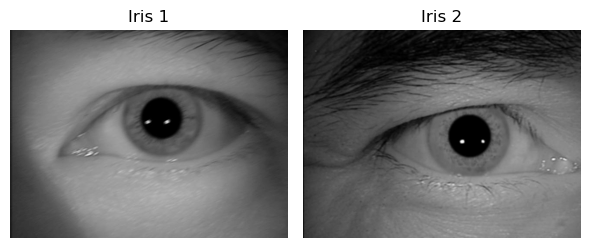

Distance between embeddings: 0.7499
❌ Different people


(False, 0.7499120831489563)

In [5]:
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt

# 1) Re‑define your preprocess (must match train/val)
preprocess = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# 2) Load your trained embedding model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = IrisEmbeddingNet(embed_dim=128).to(device)
model.load_state_dict(torch.load("E:\Iris\Methodologies\M3 - Image Embedding using triplet loss approach\iris_model.pth", map_location=device))
model.eval()

# 3) Distance threshold found on validation
THRESHOLD = 0.2474

def compare_irises(path1, path2):
    # --- Display the two images side by side ---
    imgA = Image.open(path1).convert("L")
    imgB = Image.open(path2).convert("L")
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(imgA, cmap='gray')
    axes[0].set_title("Iris 1")
    axes[0].axis('off')
    axes[1].imshow(imgB, cmap='gray')
    axes[1].set_title("Iris 2")
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

    # --- Preprocess for embedding ---
    t1 = preprocess(imgA).unsqueeze(0).to(device)  
    t2 = preprocess(imgB).unsqueeze(0).to(device)

    # --- Get embeddings ---
    with torch.no_grad():
        e1 = model(t1) 
        e2 = model(t2)

    # --- Compute Euclidean distance ---
    dist = F.pairwise_distance(e1, e2).item()
    print(f"Distance between embeddings: {dist:.4f}")

    # --- Decide same vs different ---
    if dist < THRESHOLD:
        print("✅ Same person")
        return True, dist
    else:
        print("❌ Different people")
        return False, dist

# Example usage:
compare_irises(
    r"E:\Iris\Dataset\030\S6030S01.jpg",
    r"E:\Iris\Dataset\653\S6653S03.jpg"
)


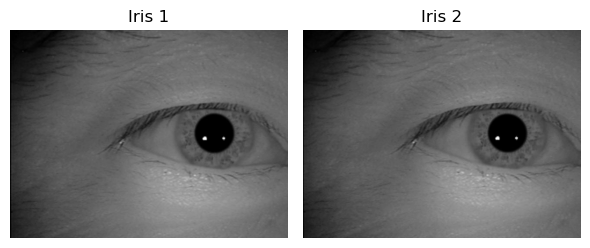

Distance between embeddings: 0.0235
✅ Same person


(True, 0.023512795567512512)

In [10]:
# Paths of the inputs
compare_irises(
    r"E:\Iris\Dataset\103\S6103S01.jpg",
    r"E:\Iris\Dataset\103\S6103S00.jpg"
)

Inspect your distance distributions and get the best threshold and accuracy 

Loaded pretrained weights for efficientnet-b0


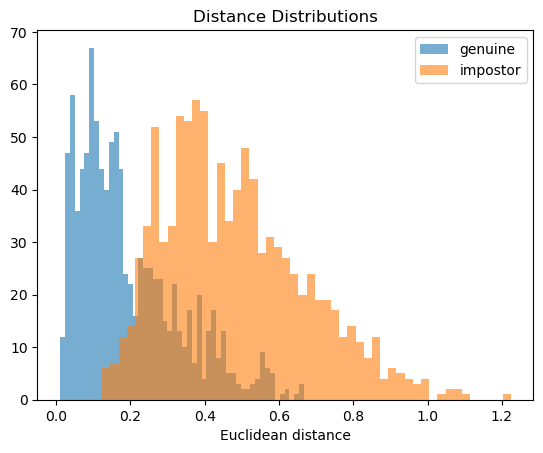

Test Best Accuracy: 0.813 at threshold = 0.2474
Test ROC‑AUC: 0.894


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
from efficientnet_pytorch import EfficientNet

# ─── Hyperparameters & device ─────────────────────────────────
NUM_PAIRS   = 2000
BATCH_SIZE  = 64
DEVICE      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ─── 1) Load your preprocessed arrays ──────────────────────────
images = np.load("iris_images_256.npy")   # shape (N,1,256,256), values ~[-1,1]
labels = np.load("iris_labels.npy")       # shape (N,)

# ─── 2) Recreate your validation/test split ────────────────────
idxs = np.arange(len(images))
_, val_idx = train_test_split(idxs, test_size=0.15, stratify=labels, random_state=42)
test_idx    = val_idx
test_images = images[test_idx]
test_labels = labels[test_idx]

# ─── 3) Preprocess (must match train/val) ───────────────────────
preprocess = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# ─── 4) Define & load your embedding model ────────────────────
class IrisEmbeddingNet(nn.Module):
    def __init__(self, embed_dim=128):
        super().__init__()
        self.net = EfficientNet.from_pretrained('efficientnet-b0')
        # Adapt to 1‑channel input
        self.net._conv_stem = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        # Replace head with embedding layer
        in_f = self.net._fc.in_features
        self.net._fc = nn.Linear(in_f, embed_dim)

    def forward(self, x):
        return self.net(x)

model = IrisEmbeddingNet(embed_dim=128).to(DEVICE)
model.load_state_dict(torch.load("iris_model.pth", map_location=DEVICE))
model.eval()

# ─── 5) Distance function ───────────────────────────────────────
def distance(i, j):
    # Convert normalized [-1,1] → uint8 [0,255] → PIL.L
    def to_pil(arr):
        im = ((arr.squeeze() + 1) / 2 * 255).clip(0,255).astype(np.uint8)
        return Image.fromarray(im, mode='L')

    pil1 = to_pil(test_images[i])
    pil2 = to_pil(test_images[j])
    t1 = preprocess(pil1).unsqueeze(0).to(DEVICE)
    t2 = preprocess(pil2).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        e1 = model(t1)
        e2 = model(t2)
    return F.pairwise_distance(e1, e2).item()

# ─── 6) Generate genuine + impostor distances ─────────────────
label_to_idxs = {
    int(l): np.where(test_labels == l)[0].tolist()
    for l in np.unique(test_labels)
}
classes = list(label_to_idxs.keys())

dists, labs = [], []
# genuine pairs
for _ in range(NUM_PAIRS // 2):
    c = random.choice([c for c in classes if len(label_to_idxs[c]) >= 2])
    i, j = random.sample(label_to_idxs[c], 2)
    dists.append(distance(i, j))
    labs.append(1)
# impostor pairs
for _ in range(NUM_PAIRS // 2):
    c1, c2 = random.sample(classes, 2)
    i = random.choice(label_to_idxs[c1])
    j = random.choice(label_to_idxs[c2])
    dists.append(distance(i, j))
    labs.append(0)

dists = np.array(dists)
labs  = np.array(labs)

# ─── 7) Plot genuine vs. impostor distributions ───────────────
plt.hist(dists[labs == 1], bins=50, alpha=0.6, label='genuine')
plt.hist(dists[labs == 0], bins=50, alpha=0.6, label='impostor')
plt.legend(); plt.xlabel('Euclidean distance'); plt.title('Distance Distributions')
plt.show()

# ─── 8) Sweep threshold for best accuracy ──────────────────────
ths, best_acc, best_thr = np.linspace(dists.min(), dists.max(), 1000), 0.0, 0.0
for thr in ths:
    preds = (dists < thr).astype(int)
    acc   = accuracy_score(labs, preds)
    if acc > best_acc:
        best_acc, best_thr = acc, thr

print(f"Test Best Accuracy: {best_acc:.3f} at threshold = {best_thr:.4f}")

# ─── 9) Also report ROC‑AUC ────────────────────────────────────
fpr, tpr, _ = roc_curve(labs, -dists)   
roc_auc     = auc(fpr, tpr)
print(f"Test ROC‑AUC: {roc_auc:.3f}")
